In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from google.colab import files
%matplotlib inline

### Подход 1: градиентный бустинг "в лоб"

##### Считайте таблицу с признаками из файла features.csv 
##### Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке

In [3]:
uploaded = files.upload()

Saving features.csv to features.csv


In [ ]:
train = pd.read_csv('features.csv', index_col='match_id')

In [5]:
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


In [ ]:
train.drop([
    'duration', 'tower_status_radiant',
    'tower_status_dire','barracks_status_radiant',
    'barracks_status_dire'], axis=1, inplace=True)

### 2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений.
##### Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [ ]:
count_nan = len(train) - train.count()

In [12]:
count_nan.sort_values(ascending=False) / len(train)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_time               0.201100
first_blood_team               0.201100
                                 ...   
d3_kills                       0.000000
d3_deaths                      0.000000
d3_items                       0.000000
d4_hero                        0.000000
start_time                     0.000000
Length: 103, dtype: float64

##### first_blood_player2 (второй игрок) - первое убийство может быть совершено одним игроком - 45%
##### radiant_flying_courier_time -  28% команда не покупает "flying_courier" сразу

### 3. Замените пропуски на нули с помощью функции fillna()

In [ ]:
train.fillna(0, inplace=True)

### 4. Какой столбец содержит целевую переменную?

In [ ]:
X_train = train.drop('radiant_win', axis=1)
y_train = train['radiant_win']

In [15]:
X_train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,23,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,0.0,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,2,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,0.0,173.0,-80.0,0.0,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,3,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,0.0,63.0,-82.0,0.0,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,11,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,0.0,0.0,0.0,0.0,208.0,-75.0,0.0,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,1,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,0.0,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


### 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки"

##### Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def score_gradbust(X: pd.DataFrame, y: pd.Series):
    scores = {}
    for n_estimators in [10, 20, 30]:
      print('number of estimators:', n_estimators)
      model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
      start = datetime.datetime.now()
      score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
      print('score:', score)
      time = datetime.datetime.now() - start
      print('Time:', time)
      scores[n_estimators] = score
      print()
    return pd.Series(scores)

number of estimators: 10
score: 0.6648506879750012
Time: 0:00:40.465769

number of estimators: 20
score: 0.6824618768044435
Time: 0:01:17.564414

number of estimators: 30
score: 0.6900064710388155
Time: 0:01:56.053783



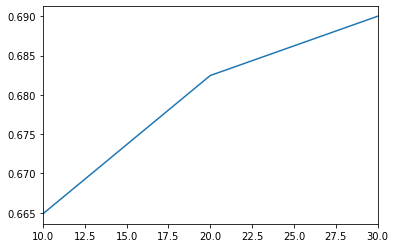

In [22]:
scores = score_gradbust(X_train, y_train)
scores.plot();

##### Кросс-валидация для градиентного бустинга с 30 деревьями по времени  0:01:56, что долго, но нормально для такого алгоритма. AUC-ROC = 0.69.
##### Как видно из графика, вполне можно увеличить чило деревьев для лучшего результата

### Подход 2: логистическая регрессия
##### 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:

def score_logreg(X: pd.DataFrame, y: pd.Series):
  scores = {}
  for i in range(-5,6):
    C = 10.0 ** i
    print('C:', C)
    model = LogisticRegression(C=C, random_state=42)
    start = datetime.datetime.now()
    score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    print('Score:', score)
    time = datetime.datetime.now() - start
    print('Time:', time)
    scores[i] = score
    print()
  return(pd.Series(scores))

C: 1e-05
Score: 0.6951552810147568
Time: 0:00:03.064846

C: 0.0001
Score: 0.7113523612276411
Time: 0:00:02.076508

C: 0.001
Score: 0.7163630589772682
Time: 0:00:03.536339

C: 0.01
Score: 0.7165498862352037
Time: 0:00:04.840894

C: 0.1
Score: 0.7165269451581027
Time: 0:00:05.077569

C: 1.0
Score: 0.7165221087939807
Time: 0:00:05.092430

C: 10.0
Score: 0.7165218906414321
Time: 0:00:05.148703

C: 100.0
Score: 0.7165218101258131
Time: 0:00:05.192745

C: 1000.0
Score: 0.7165218440198752
Time: 0:00:05.192619

C: 10000.0
Score: 0.7165218482557646
Time: 0:00:05.180101

C: 100000.0
Score: 0.7165218482557646
Time: 0:00:05.049351



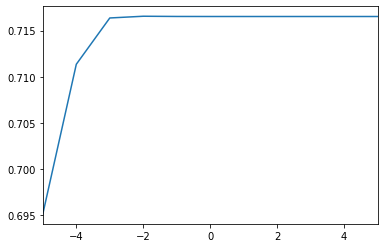

In [32]:
scores = score_logreg(X_train_scaled, y_train)
scores.plot();

In [ ]:
def best_logreg_score(scores: pd.Series):
    best_iteration = scores.sort_values(ascending=False).head(1)
    best_C = 10.0 ** best_iteration.index[0]
    best_score = best_iteration.values[0]

    print('Best AUC-ROC with C =', best_C, ' AUC-ROC =', round(best_score,2))

In [41]:
best_logreg_score(scores)

Best AUC-ROC with C = 0.01  AUC-ROC = 0.72


##### Время выполнения говорит о том что логистическая регрессия работает быстрее, лучше сначала ее применять, этот алгоритм по результату почти такой же как градиентный бустинг. Значит между откликом и переменными линейная связь

### 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей

##### Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [ ]:
hero_columns = [f'r{i}_hero' for i in range (1, 6)] + [f'd{i}_hero' for i in range (1, 6)]

In [ ]:
categorical_columns = ["lobby_type"] + hero_columns
X_train.drop(categorical_columns, axis=1, inplace=True)

C: 1e-05
Score: 0.695092064575022
Time: 0:00:01.615251

C: 0.0001
Score: 0.7113327497042613
Time: 0:00:01.966304

C: 0.001
Score: 0.7163758696833188
Time: 0:00:03.379047

C: 0.01
Score: 0.7165592000076536
Time: 0:00:04.617262

C: 0.1
Score: 0.7165338144534041
Time: 0:00:04.646225

C: 1.0
Score: 0.7165303443778955
Time: 0:00:04.705669

C: 10.0
Score: 0.7165305328738455
Time: 0:00:04.629367

C: 100.0
Score: 0.7165304163651
Time: 0:00:04.718029

C: 1000.0
Score: 0.716530420603561
Time: 0:00:04.728806

C: 10000.0
Score: 0.7165304248419043
Time: 0:00:04.787377

C: 100000.0
Score: 0.7165304248419043
Time: 0:00:04.786433



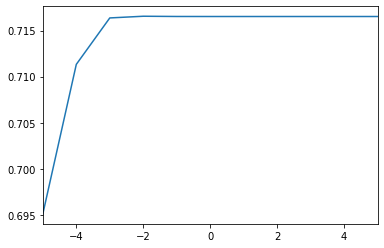

In [47]:
X_train_scaled = scaler.fit_transform(X_train)
scores = score_logreg(X_train_scaled, y_train)
scores.plot();

In [48]:
best_logreg_score(scores)

Best AUC-ROC with C = 0.01  AUC-ROC = 0.72


##### Не повлияло удаление на предсказание никак

### 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду

#### Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [ ]:
unique_heroes = np.unique(train[hero_columns].values.ravel())

In [60]:
unique_heroes

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 109, 110, 112])

In [66]:
print('Число уникальных героев в train:', len(unique_heroes))
print('Максимальный ID героя:', max(unique_heroes))

Число уникальных героев в train: 108
Максимальный ID героя: 112



### 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях.

##### Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [68]:
def get_pick(data: pd.DataFrame):
    X_pick = np.zeros((data.shape[0], max(unique_heroes)))

    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            X_pick[i, data.loc[match_id, f"r{p}_hero"] - 1] = 1
            X_pick[i, data.loc[match_id, f"d{p}_hero"] - 1] = -1

    return pd.DataFrame(X_pick, index=data.index, columns=[f"hero_{i}" for i in range(max(unique_heroes))])

X_pick = get_pick(train)
X_pick.head()

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,hero_10,hero_11,hero_12,hero_13,hero_14,hero_15,hero_16,hero_17,hero_18,hero_19,hero_20,hero_21,hero_22,hero_23,hero_24,hero_25,hero_26,hero_27,hero_28,hero_29,hero_30,hero_31,hero_32,hero_33,hero_34,hero_35,hero_36,hero_37,hero_38,hero_39,...,hero_72,hero_73,hero_74,hero_75,hero_76,hero_77,hero_78,hero_79,hero_80,hero_81,hero_82,hero_83,hero_84,hero_85,hero_86,hero_87,hero_88,hero_89,hero_90,hero_91,hero_92,hero_93,hero_94,hero_95,hero_96,hero_97,hero_98,hero_99,hero_100,hero_101,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train = pd.concat([X_train, X_pick], axis=1)

In [71]:
X_train.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_level,d1_xp,d1_gold,d1_lh,...,hero_72,hero_73,hero_74,hero_75,hero_76,hero_77,hero_78,hero_79,hero_80,hero_81,hero_82,hero_83,hero_84,hero_85,hero_86,hero_87,hero_88,hero_89,hero_90,hero_91,hero_92,hero_93,hero_94,hero_95,hero_96,hero_97,hero_98,hero_99,hero_100,hero_101,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,5,2098,1489,20,0,0,7,3,842,991,10,0,0,4,5,1909,1143,10,0,0,8,3,757,741,6,0,0,7,3,732,658,4,0,1,11,3,1058,996,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1430220345,4,1188,1033,9,0,1,12,4,1596,993,10,0,1,7,4,1506,1502,18,1,0,7,3,669,631,7,0,0,7,2,415,539,1,0,0,5,5,1960,1384,16,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1430227081,4,1319,1270,22,0,0,12,3,1314,775,6,0,0,6,3,1297,909,0,1,0,6,5,2360,2096,26,1,1,6,3,1395,1627,27,0,0,9,5,2305,2028,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1430263531,4,1779,1056,14,0,0,5,2,539,539,1,0,0,6,5,2037,1139,15,0,0,6,2,591,499,0,0,0,6,3,712,1075,12,0,0,6,5,1878,1174,17,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1430282290,4,1431,1090,8,1,0,8,2,629,552,0,0,1,7,3,884,927,0,1,0,8,3,925,1439,16,1,0,11,4,1482,880,7,0,0,8,3,704,586,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации

##### Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

C: 1e-05
Score: 0.7147781038557255
Time: 0:00:03.256915

C: 0.0001
Score: 0.7427271252298328
Time: 0:00:03.386579

C: 0.001
Score: 0.7516116548089558
Time: 0:00:05.944554

C: 0.01
Score: 0.7519639455861148
Time: 0:00:08.747907

C: 0.1
Score: 0.7519296127153968
Time: 0:00:09.641526

C: 1.0
Score: 0.7519244690811582
Time: 0:00:09.393423

C: 10.0
Score: 0.7519241577673921
Time: 0:00:09.682802

C: 100.0
Score: 0.7519241366014189
Time: 0:00:09.713537

C: 1000.0
Score: 0.7519240942211259
Time: 0:00:09.651768

C: 10000.0
Score: 0.7519240793893778
Time: 0:00:09.610947

C: 100000.0
Score: 0.751924081508455
Time: 0:00:09.601416



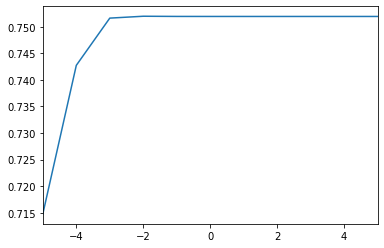

In [73]:
X_train_scaled = scaler.fit_transform(X_train)

scores = score_logreg(X_train_scaled, y_train)
scores.plot();

In [76]:
best_logreg_score(scores)

Best AUC-ROC with C = 0.01  AUC-ROC = 0.75


##### Качество модели улучшилось, это потому что у нас есть разреженная матрица, которая очень хорошо работает на линейных моделях

###  6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации)

##### Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [77]:
model = LogisticRegression(C=0.01, random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
uploaded = files.upload()

Saving features_test.csv to features_test.csv


In [ ]:
test = pd.read_csv('features_test.csv', index_col='match_id')
test.fillna(0, inplace=True)

In [ ]:
X_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)

In [ ]:
X_test.drop(categorical_columns, axis=1, inplace=True)

In [ ]:
X_test = pd.concat([X_test, get_pick(test)], axis=1)

In [87]:
X_test.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_level,d1_xp,d1_gold,d1_lh,...,hero_72,hero_73,hero_74,hero_75,hero_76,hero_77,hero_78,hero_79,hero_80,hero_81,hero_82,hero_83,hero_84,hero_85,hero_86,hero_87,hero_88,hero_89,hero_90,hero_91,hero_92,hero_93,hero_94,hero_95,hero_96,hero_97,hero_98,hero_99,hero_100,hero_101,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.514875,0.474746,-0.237743,-0.137094,-0.370005,-0.532732,1.003884,0.305165,-0.368985,0.003979,-0.304443,-0.154739,-0.530684,2.625495,0.305627,1.497577,1.986390,2.078705,1.089605,2.548233,-0.576696,-0.935309,-0.337928,-0.451603,-0.179721,0.436965,-0.524238,-0.574233,-0.931472,-0.321391,0.341913,-0.315164,-0.766382,-0.520831,-0.574775,0.286089,-0.458720,-0.207894,-0.433700,-0.689819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.513895,-1.365630,-1.207913,-1.255660,-1.145090,-0.532732,-0.593200,0.305165,0.567766,0.023887,0.635111,1.185010,-0.530684,-0.578521,-0.525490,0.566666,0.343576,-0.076035,0.303071,-0.526977,1.019230,-0.105828,-1.270990,-0.710585,-0.776060,-1.130442,1.021658,-0.574233,-0.112267,1.557942,1.996586,1.583373,1.601574,-0.520831,-0.574775,-0.943164,-0.458720,-0.585577,-0.388057,0.530232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.512377,-1.365630,-0.862057,-0.742715,-1.145090,-0.532732,-0.593200,1.898546,-1.305736,-1.375081,-1.179583,-0.824614,-0.530684,-0.578521,-0.941049,-0.364246,-0.399730,-0.445796,-0.820550,1.010628,2.615155,-0.935309,1.528198,1.287019,0.939801,1.444585,-0.524238,-0.574233,-0.112267,0.618275,0.772855,1.152090,1.827094,-0.520831,-0.574775,-1.762666,-0.458720,-0.979220,-1.029242,-1.133474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.508381,-0.445442,-0.938323,-0.537967,-1.145090,0.968865,1.003884,1.101855,-1.305736,-0.920823,-0.442155,-0.489676,-0.530684,-0.578521,-0.109932,1.497577,1.720667,1.160904,1.988501,-0.526977,-0.576696,-0.520569,0.595135,0.747322,2.398504,2.004373,2.567553,-0.574233,-0.521870,1.557942,1.461999,1.318823,1.939854,-0.520831,-0.574775,-0.123662,0.463282,0.027937,-0.966210,-0.689819,...,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.507087,0.474746,0.038942,-1.059534,-0.812911,-0.532732,-0.593200,0.305165,1.504517,0.945070,-0.302222,-0.043093,-0.530684,1.023487,-0.941049,-0.364246,-0.150166,-0.344552,-0.932912,1.010628,-0.576696,-0.935309,-0.337928,0.214869,-0.164203,-0.010865,-0.524238,-0.574233,-0.112267,-1.261058,-1.221843,-1.035452,-0.653622,-0.520831,-0.574775,-0.123662,0.463282,1.833017,1.155134,0.530232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
predict = pd.Series(model.predict_proba(X_test)[:, 1])

In [89]:
predict.describe()

count    17177.000000
mean         0.519833
std          0.210691
min          0.006641
25%          0.361368
50%          0.522007
75%          0.682869
max          0.995368
dtype: float64

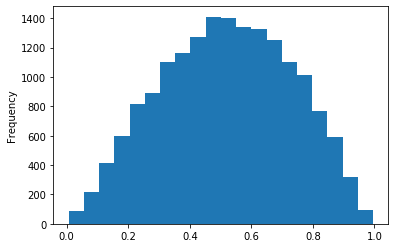

In [91]:
predict.plot.hist(bins=20);